In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k

###################################
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1 # 0.5 for Half

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))


Using TensorFlow backend.


In [3]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model

import tensorflow as tf
import keras
import seaborn as sn
import pandas as pd
import numpy as np
import linecache
import sys
import h5py
import itertools
import matplotlib.pyplot as plt
import os
import pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

In [4]:
tf.__version__

'1.9.0'

In [5]:
train_path = '/data/danish/Data/Malimg-Gray-25-Families/Malimg_Grayscale_train/'
test_path  = '/data/danish/Data/Malimg-Gray-25-Families/Malimg_Grayscale_test/'

In [6]:
datagen_train = ImageDataGenerator(
      rescale=1./255#,
      #rotation_range=0.1,#180,
      #width_shift_range=0.1,
      #height_shift_range=0.1,
      #shear_range=0.1,
      #zoom_range=0.1,#[0.9, 1.5],
      #horizontal_flip=True,
      #vertical_flip=True,
      #fill_mode='nearest'
                )

datagen_test = ImageDataGenerator(rescale=1./255)


In [7]:
if False:
    save_to_dir='augmented_images/'
else:
    save_to_dir = None

In [8]:
input_shape=(224,224)
batch_size=32
save_fn='Deep_Learning_Model_for_Malimg_size_GrayScale='+str(input_shape[:])
save_fn

'Deep_Learning_Model_for_Malimg_size_GrayScale=(224, 224)'

In [9]:
generator_train = datagen_train.flow_from_directory(directory=train_path,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',#binary
                                                    color_mode="rgb",
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir,
                                                    seed=42)


steps_train = generator_train.n/ batch_size
print("Steps for Training",steps_train)

cls_train = generator_train.classes
print(cls_train)
cls_names_train = list(generator_train.class_indices.keys())
print(cls_names_train)
num_cls_train = len(cls_names_train)
print("Number of Classes in Training Data",num_cls_train)

Found 6527 images belonging to 25 classes.
Steps for Training 203.96875
[ 0  0  0 ..., 24 24 24]
['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'ObfuscatorAD', 'Rbot!gen', 'Skintrim.N', 'Swizzorgen!E', 'Swizzorgen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']
Number of Classes in Training Data 25


In [10]:
from sklearn.utils.class_weight import compute_class_weight
class_weight_train = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

In [11]:
#cls_names_train
class_labels = ['AdialerC','AgentFYI','AllapleA','AllapleL','Aluerongen!J','AutorunK','C2LOPP','C2LOPgen!g','DialplatformB','DontovoA',
 'Fakerean','Instantaccess','LolydaAA1','LolydaAA2','LolydaAA3','LolydaAT','Malexgen!J','ObfuscatorAD','Rbot!gen','SkintrimN',
 'Swizzorgen!E','Swizzorgen!I','VBAT','WintrimBX','YunerA']
class_labels

['AdialerC',
 'AgentFYI',
 'AllapleA',
 'AllapleL',
 'Aluerongen!J',
 'AutorunK',
 'C2LOPP',
 'C2LOPgen!g',
 'DialplatformB',
 'DontovoA',
 'Fakerean',
 'Instantaccess',
 'LolydaAA1',
 'LolydaAA2',
 'LolydaAA3',
 'LolydaAT',
 'Malexgen!J',
 'ObfuscatorAD',
 'Rbot!gen',
 'SkintrimN',
 'Swizzorgen!E',
 'Swizzorgen!I',
 'VBAT',
 'WintrimBX',
 'YunerA']

In [12]:
class_weight_train

array([ 3.07152941,  3.22320988,  0.12649225,  0.23457323,  1.89188406,
        3.52810811,  2.55960784,  1.86485714,  2.12260163,  2.31044248,
        0.98150376,  0.86737542,  1.75221477,  2.0396875 ,  3.03581395,
        2.35207207,  2.74821053,  2.63717172,  2.37345455,  4.66214286,
        2.93348315,  2.83782609,  0.91607018,  3.89671642,  0.46621429])

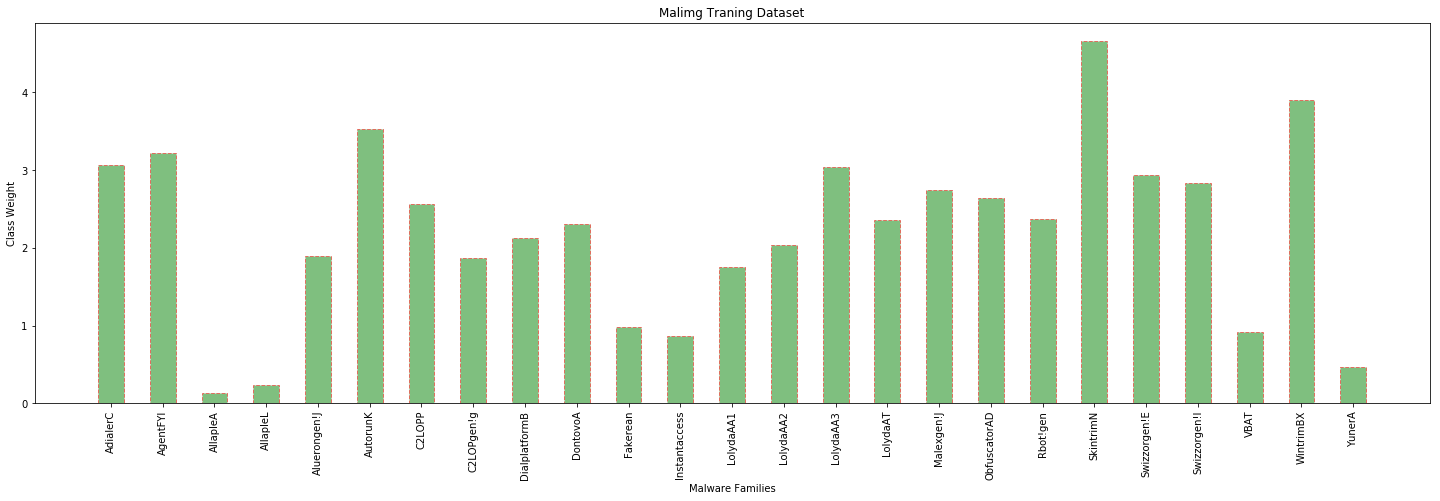

In [13]:
objects = class_labels#class_dictionary_train#cls_names_train#('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = class_weight_train#[10,8,6,4,2,1]
plt.figure(figsize = (25,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='g', linestyle='--', width=0.5, edgecolor='r', )
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Malware Families')
plt.ylabel('Class Weight')
plt.title('Malimg Traning Dataset')
 
plt.show()

In [14]:
generator_test = datagen_test.flow_from_directory(directory=test_path,
                                                  target_size=input_shape,
                                                  class_mode='categorical',
                                                  color_mode="rgb",
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=42)

steps_test = generator_test.n / batch_size
steps_test
print("Steps for Test",steps_test)

cls_test = generator_test.classes
print(cls_test)
cls_names_test = list(generator_test.class_indices.keys())
print(cls_names_test)
num_cls_test = len(cls_names_test)
print("Number of Classes in Test Data",num_cls_test)

Found 2812 images belonging to 25 classes.
Steps for Test 87.875
[ 0  0  0 ..., 24 24 24]
['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'ObfuscatorAD', 'Rbot!gen', 'Skintrim.N', 'Swizzorgen!E', 'Swizzorgen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']
Number of Classes in Test Data 25


In [15]:
class_dictionary_test = generator_test.class_indices
class_dictionary_test

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'ObfuscatorAD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzorgen!E': 20,
 'Swizzorgen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [16]:
from sklearn.utils.class_weight import compute_class_weight
class_weight_test = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_test),
                                    y=cls_test)

In [17]:
class_weight_test

array([ 3.04      ,  3.21371429,  0.12709605,  0.23531381,  1.87466667,
        3.515     ,  2.55636364,  1.87466667,  2.08296296,  2.2955102 ,
        0.97808696,  0.86523077,  1.7575    ,  2.00857143,  3.04      ,
        2.34333333,  2.74341463,  2.61581395,  2.34333333,  4.68666667,
        2.88410256,  2.812     ,  0.91447154,  3.74933333,  0.46866667])

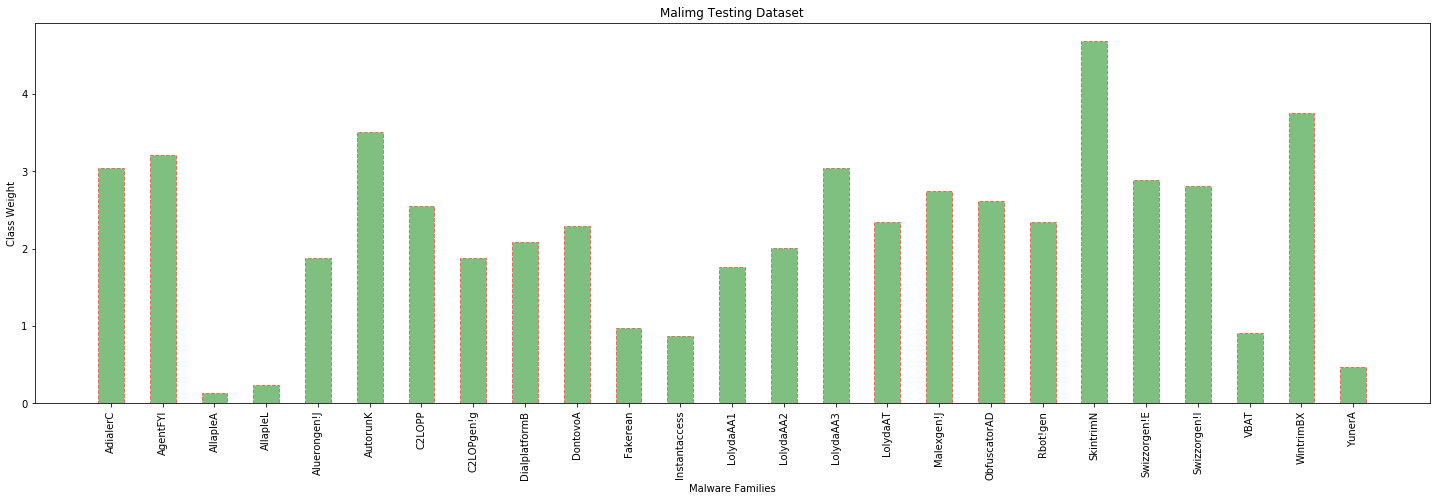

In [18]:
objects = class_labels#class_dictionary_train#cls_names_train#('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = class_weight_test#[10,8,6,4,2,1]
plt.figure(figsize = (25,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='g', linestyle='--', width=0.5, edgecolor='r', )
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Malware Families')
plt.ylabel('Class Weight')
plt.title('Malimg Testing Dataset')
 
plt.show()

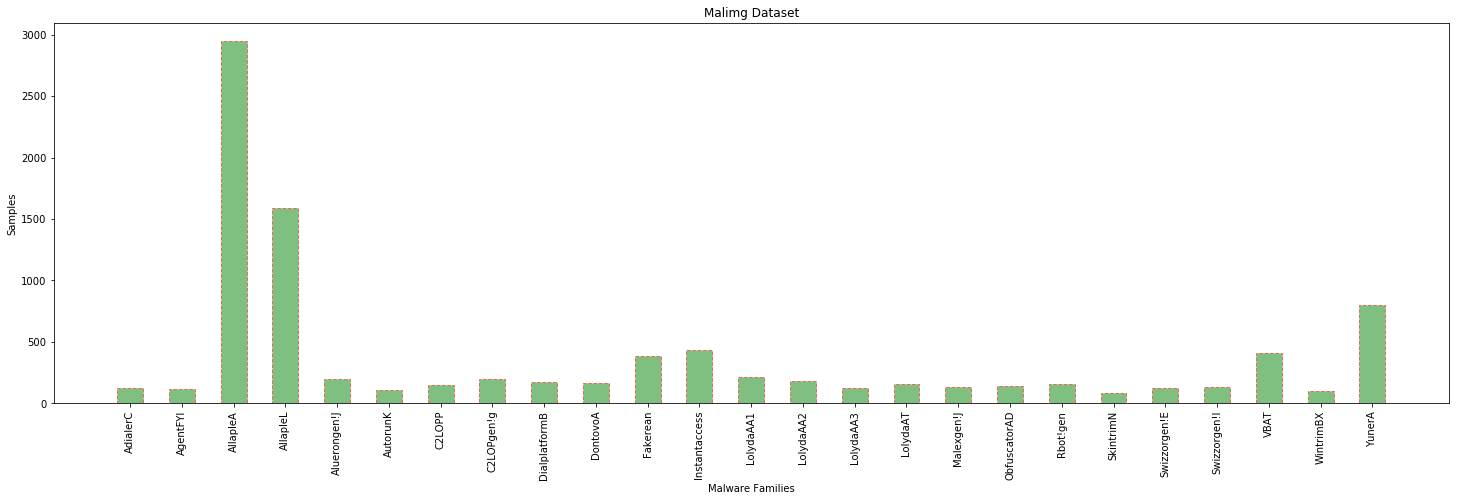

In [19]:
objects = class_labels#class_dictionary_train#cls_names_train#('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = [122,116,2949,1591,198,106,146,200,177,162,381,431,213,184,123,159,136,142,158,80,128,132,408,97,800]
plt.figure(figsize = (25,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='g', linestyle='--', width=0.5, edgecolor='r', )
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Malware Families')
plt.ylabel('Samples')
plt.title('Malimg Dataset')
 
plt.show()

transfer_layer = model_.get_layer('fc2')

transfer_layer.output

conv_model = Model(inputs=model_.input,
                   outputs=transfer_layer.output)

conv_model.summary()

In [23]:
from keras.models import load_model

#model = load_model('IMCFN-Grayscale.h5')
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
epochs =10
steps_per_epoch=steps_train

In [ ]:


history = model.fit_generator(generator=generator_train,
                                epochs=epochs,
                                steps_per_epoch=steps_per_epoch,
                                class_weight=class_weight_train,
                                validation_data=generator_test,
                                validation_steps=steps_test
                                )




In [ ]:
model.save("IMCFN-Grayscale.h5")

In [ ]:
#####################################
# write Traning History to a file
output = open('IMCFN-Grayscale-History.pkl', 'wb')
pickle.dump(history.history, output)
output.close()
#####################################

In [24]:

# read Traning History back from the file
pkl_file = open('IMCFN-Grayscale-History.pkl', 'rb')
history = pickle.load(pkl_file)
pkl_file.close()

In [25]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history) 

csv_file = 'IMCFN-Grayscale.csv'
with open(csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [26]:
#scores = model.evaluate(X[test], Y[test], verbose=0)
#model.load_weights('Model_VGG16_Malimg_RGB_Trained_(229, 229)_Epochs=100_Model_Traning_Testing_Weights.hdf5')
scores = model.evaluate_generator(generator_test, verbose=1)# steps_test, max_queue_size=10, workers=1, use_multiprocessing=False,verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

88/88 [==============================] - 17s 195ms/step
acc: 98.47%


In [27]:
cls_pred = model.predict_generator(generator_test, verbose=1)#, steps_test, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)

88/88 [==============================] - 14s 155ms/step


In [28]:
cls_pred = np.argmax(cls_pred, axis=1)

In [29]:
y_test = cls_test = generator_test.classes

from pycm import ConfusionMatrix
CM_IMCFN = ConfusionMatrix(y_test,cls_pred)
file = open('CM-IMCFN-Grayscale.pkl', 'wb')
pickle.dump(CM_IMCFN, file)
file.close()

In [30]:
# write Traning History to a file
file = open('CM-IMCFN-Grayscale.pkl', 'rb')
CM_IMCFN = pickle.load(file)
file.close()

In [31]:
CM_IMCFN.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.99878
F1 Macro                                                          0.96162
Kappa                                                             0.98209
Overall ACC                                                       0.98471
PPV Macro                                                         0.96326
SOA1(Landis & Koch)                                               Almost Perfect
TPR Macro                                                         0.96102
Zero-one Loss                                                     43

Class Statistics :

Classes                                                           0             1             10            11            12            13            14            15            16            17            18            19            2             20            21            22            23            24            3             4             5             6 

/home/danish/anaconda3/envs/tf/lib/python3.6/site-packages/pycm/pycm_obj.py:167: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
The save_csv method can be used to save the confusion matrix in csv format and have a better demonstration of it.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


In [32]:
CM_IMCFN.save_csv("CM-IMCFN-Grayscale",address=True)

{'Status': True,
 'Message': '/data/danish/ImgProPython/TensorFlow-Tutorials/Computer-Networks-(CCF-B)/Grayscale/CM-IMCFN-Grayscale.csv'}

In [33]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    plt.figure(figsize = (25,7))
    acc = history['acc']
    loss = history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history['val_acc']
    val_loss = history['val_loss']

    
    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='--', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')
    
    # Plot title and legend.
    plt.title('Training and Testing ')
    plt.ylabel('Accuracy & Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='upper left')
    plt.savefig(save_fn+'_Graph.png', bbox_inches='tight')
    # Ensure the plot shows correctly.
    plt.show()

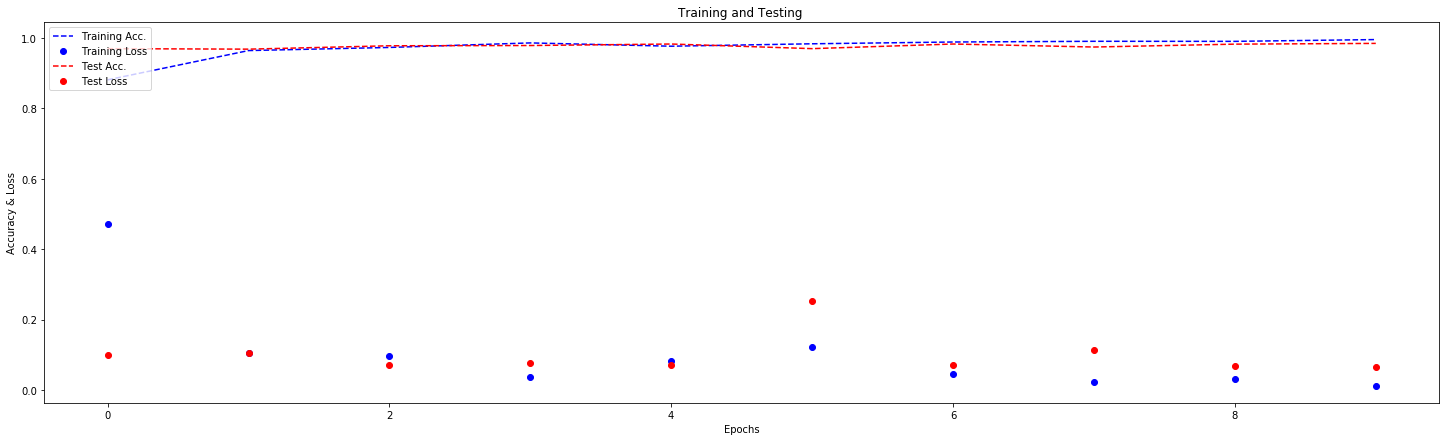

In [34]:
plot_training_history(history)

In [35]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = cls_test = generator_test.classes#data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,y_pred=cls_pred)
    
    #if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        #print("Normalized Confusion Matrix")
    #else:
        #print("Confusion Matrix without Normalization")
    plt.figure(figsize = (25,10))
    sn.set(font_scale=1)#for label size
    sn.heatmap(cm, annot=True,annot_kws={"size": 10})# font size
    tick_marks = np.arange(num_cls_test)
    plt.xticks(tick_marks, class_labels,rotation='vertical')
    plt.yticks(tick_marks, class_labels,rotation='horizontal')
    plt.xlabel('Predicted Values')
    plt.ylabel('Ground Truth')
    plt.savefig(save_fn+'_confusion_matrix_heatmap.png', bbox_inches='tight')
    plt.show()
    # Print the confusion matrix as text.
    #print(cm)
    
    
    plt.figure(figsize = (25,10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_cls_test)
    plt.xticks(tick_marks, class_labels,rotation=45)#rotation='vertical')
    plt.yticks(tick_marks, class_labels,rotation=45)#rotation='horizontal')
    #print(cm) 
   
    #thresh = cm.max()/2.
    #for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1] )):
    #    plt.text(j,i,cm[i,j],
    #             horizontalalignment="center",
    #             color="white" if cm[i,j]>thresh else "black")
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.tight_layout()
    plt.xlabel('Predicted Values')
    plt.ylabel('Ground Truth')
    plt.savefig(save_fn+'_confusion_matrix_Simple.png', bbox_inches='tight')
    plt.show()

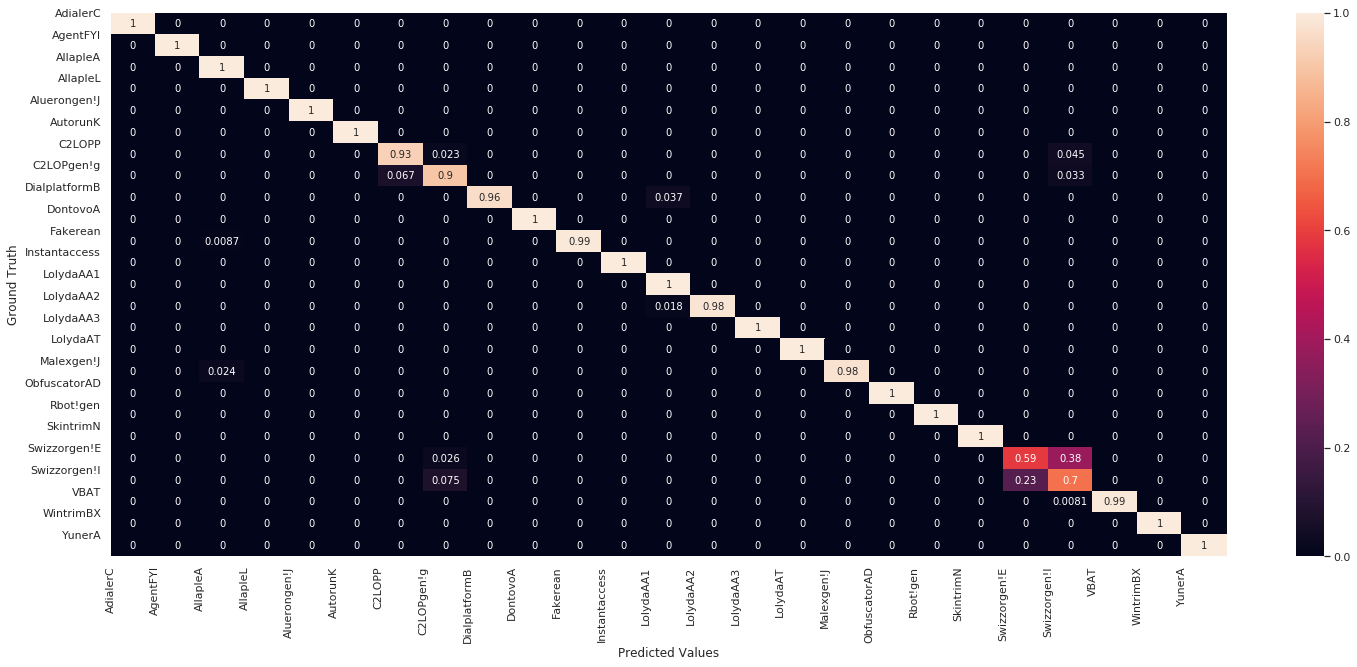

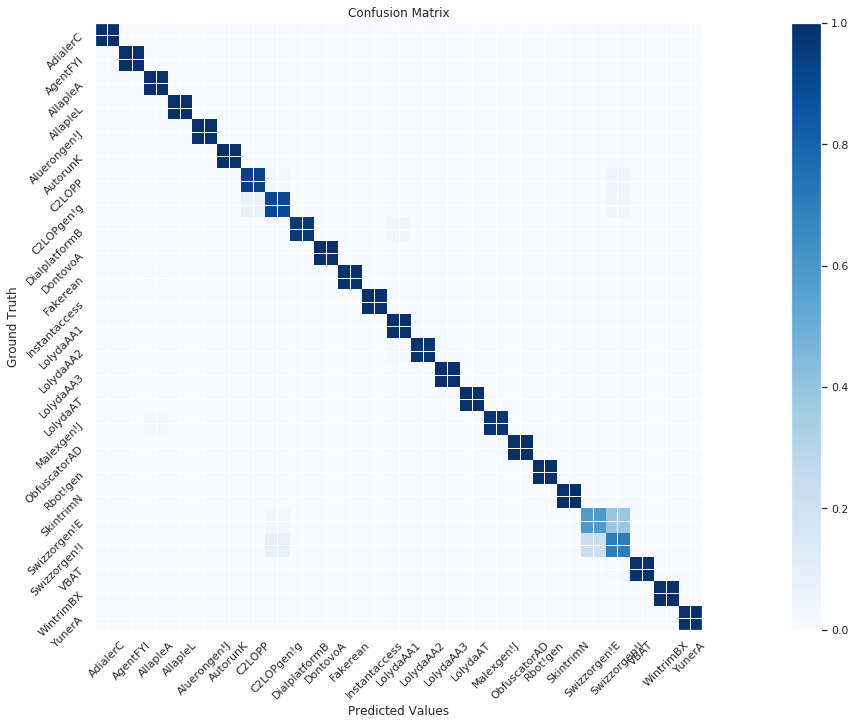

In [36]:
plot_confusion_matrix(cls_pred=cls_pred)

In [37]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average=None)

print("All Classes")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

All Classes
Precision:  [ 1.          1.          0.99774521  1.          1.          1.
  0.91111111  0.91525424  1.          1.          1.          1.
  0.95522388  1.          1.          1.          1.          1.          1.
  1.          0.71875     0.58333333  1.          1.          1.        ]
Recall:  [ 1.          1.          1.          1.          1.          1.
  0.93181818  0.9         0.96296296  1.          0.99130435  1.          1.
  0.98214286  1.          1.          0.97560976  1.          1.          1.
  0.58974359  0.7         0.99186992  1.          1.        ]
F1 score:  [ 1.          1.          0.99887133  1.          1.          1.
  0.92134831  0.90756303  0.98113208  1.          0.99563319  1.
  0.97709924  0.99099099  1.          1.          0.98765432  1.          1.
  1.          0.64788732  0.63636364  0.99591837  1.          1.        ]
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.8 ms


In [38]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average='micro')

print("Micro")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

Micro
Precision:  0.984708392603
Recall:  0.984708392603
F1 score:  0.984708392603
CPU times: user 1.76 ms, sys: 3.35 ms, total: 5.1 ms
Wall time: 8.47 ms


In [39]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average='macro')

print("Macro")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

Macro
Precision:  0.963256710836
Recall:  0.961018064572
F1 score:  0.961618472447
CPU times: user 4.84 ms, sys: 0 ns, total: 4.84 ms
Wall time: 4.1 ms


In [40]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average='weighted')

print("weighted")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

weighted
Precision:  0.985244510811
Recall:  0.984708392603
F1 score:  0.98478555077
CPU times: user 5.17 ms, sys: 343 µs, total: 5.51 ms
Wall time: 4.22 ms


In [41]:
def plot_history(history):
    loss_list = [s for s in history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.keys() if 'acc' in s and 'val' in s]
    plt.figure(figsize = (25,7))
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history[l], 'b', label='Training loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history[l], 'g', label='Testing loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(save_fn+'_Graph#######LOSS.png', bbox_inches='tight')
    
    
    ## Accuracy
    plt.figure(figsize = (25,7))
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history[l], 'b', label='Training accuracy (' + str(format(history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history[l], 'g', label='Testing accuracy (' + str(format(history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(save_fn+'_Graph#######ACC.png', bbox_inches='tight')
    plt.show()

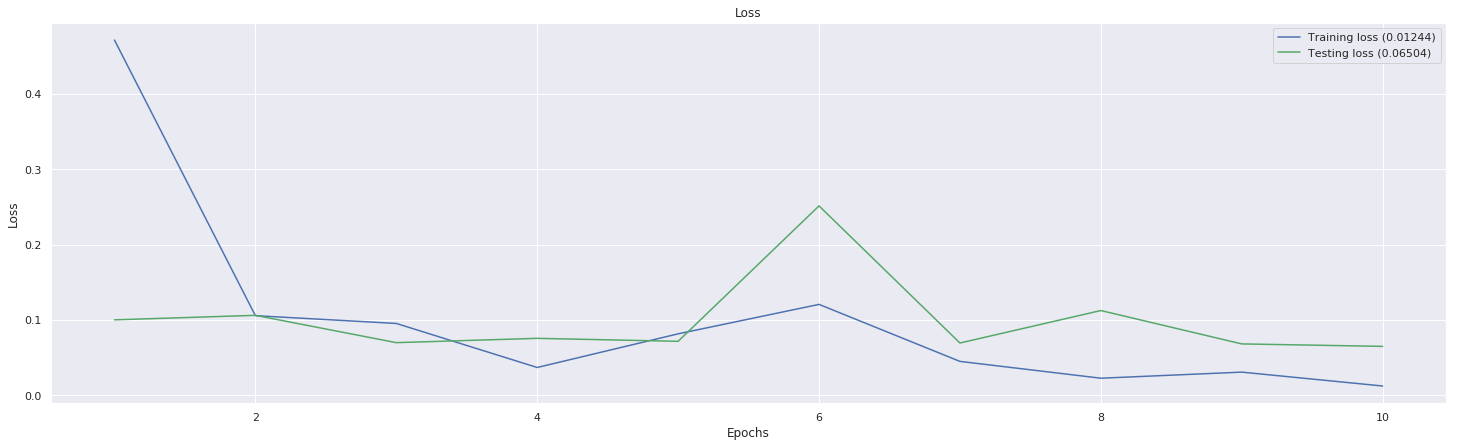

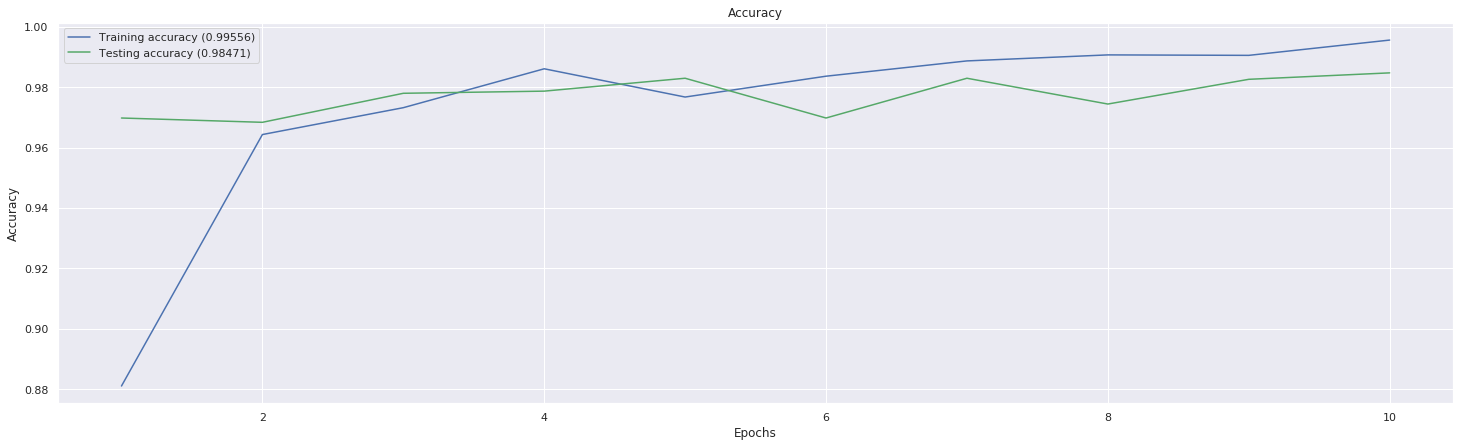

In [42]:
plot_history(history)